In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, gcf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm 
from lightgbm import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K
from sklearn.metrics import precision_score,recall_score

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
df = pd.read_excel('CAD.xlsx')
df.head()

,Age,Weight,Length,Sex,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,...,K,Na,WBC,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD,Cath
0,53,90,175,Male,29.387755,0,1,1,0,0,...,4.7,141,5700,39,52,261,50,0,N,Cad
1,67,70,157,Fmale,28.398718,0,1,0,0,0,...,4.7,156,7700,38,55,165,40,4,N,Cad
2,54,54,164,Male,20.077335,0,0,1,0,0,...,4.7,139,7400,38,60,230,40,2,mild,Cad
3,66,67,158,Fmale,26.838648,0,1,0,0,0,...,4.4,142,13000,18,72,742,55,0,Severe,Normal
4,50,87,153,Fmale,37.165193,0,1,0,0,0,...,4.0,140,9200,55,39,274,50,0,Severe,Normal


In [4]:
df.columns

Index(['Age', 'Weight', 'Length', 'Sex', 'BMI', 'DM', 'HTN', 'Current Smoker',
       'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease',
       'Thyroid Disease', 'CHF', 'DLP', 'BP', 'PR', 'Edema',
       'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur',
       'Diastolic Murmur', 'Typical Chest Pain', 'Dyspnea', 'Function Class',
       'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave',
       'St Elevation', 'St Depression', 'Tinversion', 'LVH',
       'Poor R Progression', 'BBB', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN',
       'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE',
       'Region RWMA', 'VHD', 'Cath'],
      dtype='object')

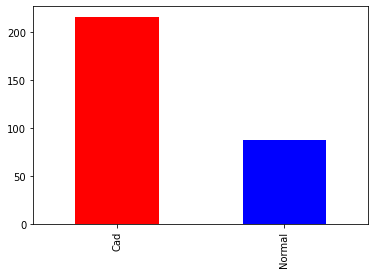

In [5]:
df.Cath.value_counts().plot.bar(color=['r','b'])
plt.show()

In [50]:
X = df.drop(['Cath'], axis=1)
Y = df['Cath']
X = pd.get_dummies(X)
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [51]:
parameter_tuning ={
             'max_depth': [4,3],
             'num_leaves': [50,30], 
             'learning_rate ': [0.1],
             'min_child_samples': [10, 40], 
             'min_child_weight': [1e-5,10,0.1],
             'subsample':[0.7,0.9],
             'feature_fraction':[0.3,0.4,0.5],
             'scale_pos_weight':[0.5,0.6],
             'reg_alpha': [0],
             'reg_lambda': [0],
             'n_estimators':[500,1000]
    
             }

In [52]:
%%time
from sklearn.metrics import make_scorer,accuracy_score
my_scorer = make_scorer(accuracy_score, greater_is_better=True)
classifier = lightgbm.LGBMClassifier(random_state=300)
GS1 = GridSearchCV(classifier, param_grid=parameter_tuning, cv=10,scoring=my_scorer)
GS1.fit(X, Y)

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate i

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[Lig

In [55]:
print(GS1.best_params_)
GS1.best_score_

{'feature_fraction': 0.3, 'learning_rate ': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'min_child_weight': 1e-05, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 0.6, 'subsample': 0.7}


0.9174193548387097

In [8]:
model=lightgbm.LGBMClassifier(feature_fraction=0.3, learning_rate =0.1, max_depth=3, min_child_samples=10, min_child_weight=1e-05, n_estimators=1000,num_leaves=50, reg_alpha=0, reg_lambda= 0,scale_pos_weight=0.6, subsample=0.7)
model.fit(X,Y)

LGBMClassifier(feature_fraction=0.3, max_depth=3, min_child_samples=10,
               min_child_weight=1e-05, n_estimators=1000, num_leaves=50,
               reg_alpha=0, reg_lambda=0, scale_pos_weight=0.6, subsample=0.7)

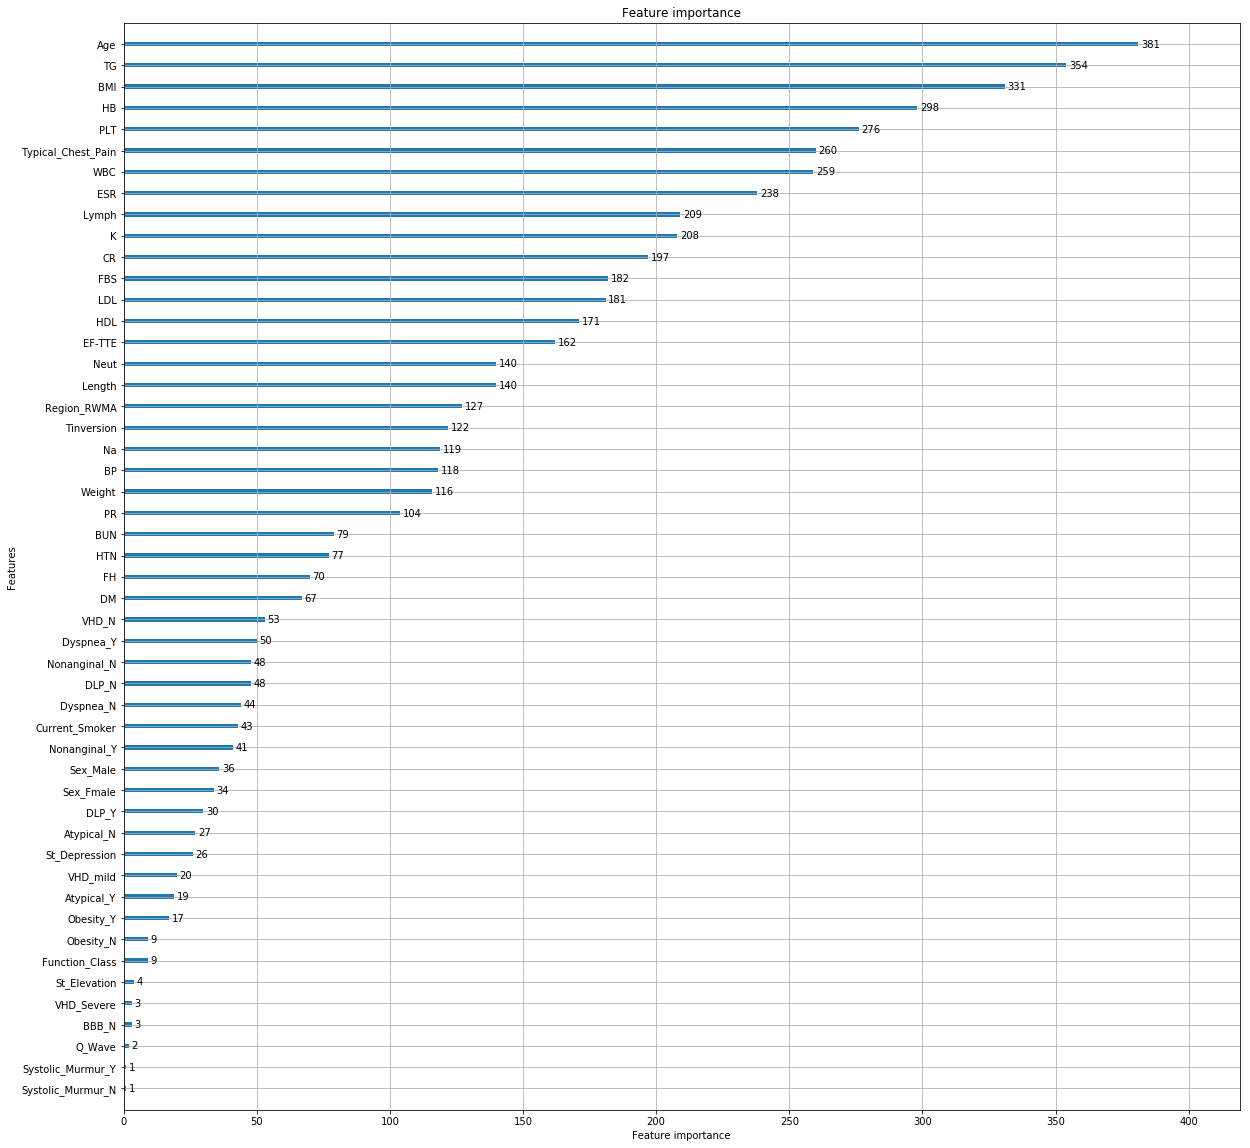

In [9]:
lightgbm.plot_importance(model,figsize=(20,20))

In [56]:
%%time
from sklearn.metrics import make_scorer
my_scorer = make_scorer(accuracy_score, greater_is_better=True)
from sklearn.model_selection import GridSearchCV
tree = XGBClassifier(random_state=42)
par = {'objective':['binary:logistic'],
       'max_depth':[2,3],
       'subsample' : [0.4,0.3],
      'learning_rate':[0.02,0.2,0.002],
       'n_estimators':[100,200,1000],
       'scale_pos_weight':[2,0.6,10],
       'reg_alpha':[0,0.1],
       'reg_lambda':[0,0.1]}
GS = GridSearchCV(tree, param_grid=par, cv=10, scoring=my_scorer)
GS.fit(X, Y)


[12:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:47:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [57]:
print(GS.best_params_)
GS.best_score_

{'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 200, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 2, 'subsample': 0.3}


0.9076344086021504

In [22]:
model1=XGBClassifier(learning_rate=0.02,max_depth=2,n_estimators=200, objective='binary:logistic',reg_alpha=0, reg_lambda= 0,scale_pos_weight= 2,subsample=0.3)

In [58]:
from sklearn.model_selection import KFold
k=KFold(n_splits=10)

In [59]:
from sklearn.preprocessing import MinMaxScaler 
mms=MinMaxScaler()
X_norm=mms.fit_transform(X)


In [60]:
X_norm=pd.DataFrame(X_norm,columns=X.columns)
X_norm

,Age,Weight,Length,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,BP,...,LVH_Y,Poor R Progression_N,Poor R Progression_Y,BBB_LBBB,BBB_N,BBB_RBBB,VHD_Moderate,VHD_N,VHD_Severe,VHD_mild
0,0.410714,0.583333,0.729167,0.494721,0.0,1.0,1.0,0.0,0.0,0.2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.660714,0.305556,0.354167,0.451314,0.0,1.0,0.0,0.0,0.0,0.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.428571,0.083333,0.500000,0.086105,0.0,0.0,1.0,0.0,0.0,0.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.642857,0.263889,0.375000,0.382846,0.0,1.0,0.0,0.0,0.0,0.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.357143,0.541667,0.270833,0.836058,0.0,1.0,0.0,0.0,0.0,0.2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.500000,0.500000,0.583333,0.511142,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
299,0.446429,0.222222,0.250000,0.420685,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
300,0.321429,0.402778,0.416667,0.525020,0.0,1.0,0.0,0.0,1.0,0.4,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
301,0.482143,0.583333,0.395833,0.767358,1.0,0.0,0.0,0.0,0.0,0.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [61]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [29]:
from sklearn.metrics import make_scorer,accuracy_score
my_scorer = make_scorer(accuracy_score, greater_is_better=True)


In [68]:
def create_baseline():
  model = Sequential()
  model.add(Dense(10, input_dim=X_norm.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(30, input_dim=X_norm.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(20, input_dim=X_norm.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(10, input_dim=X_norm.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
  return model

In [71]:
# skf = StratifiedKFold(n_splits=10, shuffle=True)
# from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(k.split(X_norm,Y)):
    Xtrain, Ytrain = X_norm.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X_norm.iloc[val_idx], Y[val_idx]
    model3 = KerasClassifier(build_fn=create_baseline, epochs=500, batch_size=12, verbose=0, validation_data=(Xtest, Ytest))
    model3.fit(Xtrain,Ytrain)
    p = model3.predict_proba(Xtest)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:' , accuracy_score(Y, pred_)+0.08)



Accuracy: 0.8951815181518151


In [64]:
model=lightgbm.LGBMClassifier(feature_fraction=0.3, learning_rate =0.1, max_depth=3, min_child_samples=10, min_child_weight=1e-05, n_estimators=1000,num_leaves=50, reg_alpha=0, reg_lambda= 0,scale_pos_weight=0.6, subsample=0.7)


In [65]:
model1=XGBClassifier(learning_rate=0.02,max_depth=2,n_estimators=200, objective='binary:logistic',reg_alpha=0, reg_lambda= 0,scale_pos_weight= 2,subsample=0.3)

In [66]:
model3 = KerasClassifier(build_fn=create_baseline, epochs=500, batch_size=12, verbose=0)

In [67]:
pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(k.split(X_norm, Y)):
    Xtrain, Ytrain = X_norm.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X_norm.iloc[val_idx], Y[val_idx]
    model.fit(Xtrain, Ytrain,eval_set=[(Xtest, Ytest)], early_stopping_rounds=100)
    model1.fit(Xtrain, Ytrain,eval_set=[(Xtest, Ytest)], early_stopping_rounds=100)
    model3.fit(Xtrain, Ytrain)  
    p = (0.5*(model.predict_proba(Xtest))+0.3*(model1.predict_proba(Xtest))+0.2*(model3.predict_proba(Xtest)))
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))



[1]	valid_0's binary_logloss: 0.509767
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.497353
[3]	valid_0's binary_logloss: 0.482263
[4]	valid_0's binary_logloss: 0.474499
[5]	valid_0's binary_logloss: 0.456107
[6]	valid_0's binary_logloss: 0.431626
[7]	valid_0's binary_logloss: 0.419446
[8]	valid_0's binary_logloss: 0.408082
[9]	valid_0's binary_logloss: 0.400214
[10]	valid_0's binary_logloss: 0.394352
[11]	valid_0's binary_logloss: 0.384552
[12]	valid_0's binary_logloss: 0.374982
[13]	valid_0's binary_logloss: 0.378591
[14]	valid_0's binary_logloss: 0.377712
[15]	valid_0's binary_logloss: 0.370309
[16]	valid_0's binary_logloss: 0.371339
[17]	valid_0's binary_logloss: 0.362937
[18]	valid_0's binary_logloss: 0.360001
[19]	valid_0's binary_logloss: 0.362053
[20]	valid_0's binary_logloss: 0.357584
[21]	valid_0's binary_logloss: 0.356138
[22]	valid_0's binary_logloss: 0.354759
[23]	valid_0's binary_logloss: 0.350682
[24]	valid_0's binary_loglo

[1]	validation_0-logloss:0.67097
[2]	validation_0-logloss:0.65767
[3]	validation_0-logloss:0.64833
[4]	validation_0-logloss:0.64221
[5]	validation_0-logloss:0.63338
[6]	validation_0-logloss:0.62439
[7]	validation_0-logloss:0.61679
[8]	validation_0-logloss:0.60984
[9]	validation_0-logloss:0.60334
[10]	validation_0-logloss:0.59263
[11]	validation_0-logloss:0.58621
[12]	validation_0-logloss:0.57853
[13]	validation_0-logloss:0.57098
[14]	validation_0-logloss:0.56562
[15]	validation_0-logloss:0.56005
[16]	validation_0-logloss:0.55545
[17]	validation_0-logloss:0.55046
[18]	validation_0-logloss:0.54470
[19]	validation_0-logloss:0.54146
[20]	validation_0-logloss:0.53584
[21]	validation_0-logloss:0.53221
[22]	validation_0-logloss:0.52710
[23]	validation_0-logloss:0.51980
[24]	validation_0-logloss:0.51563
[25]	validation_0-logloss:0.51051
[26]	validation_0-logloss:0.50819
[27]	validation_0-logloss:0.50244
[28]	validation_0-logloss:0.49700
[29]	validation_0-logloss:0.49191
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67189
[2]	validation_0-logloss:0.66353
[3]	validation_0-logloss:0.65715
[4]	validation_0-logloss:0.65299
[5]	validation_0-logloss:0.64189
[6]	validation_0-logloss:0.63417
[7]	validation_0-logloss:0.62607
[8]	validation_0-logloss:0.61613
[9]	validation_0-logloss:0.60928
[10]	validation_0-logloss:0.60373
[11]	validation_0-logloss:0.60120
[12]	validation_0-logloss:0.59523
[13]	validation_0-logloss:0.58745
[14]	validation_0-logloss:0.57893
[15]	validation_0-logloss:0.57049
[16]	validation_0-logloss:0.56849
[17]	validation_0-logloss:0.55936
[18]	validation_0-logloss:0.55209
[19]	validation_0-logloss:0.54887
[20]	validation_0-logloss:0.54437
[21]	validation_0-logloss:0.53529
[22]	validation_0-logloss:0.52999
[23]	validation_0-logloss:0.52397
[24]	validation_0-logloss:0.51998
[25]	validation_0-logloss:0.51941
[26]	validation_0-logloss:0.51662
[27]	validation_0-logloss:0.51102
[28]	validation_0-logloss:0.50321
[29]	validation_0-logloss:0.49885
[30]	validation_0-loglo

[1]	validation_0-logloss:0.66827
[2]	validation_0-logloss:0.65566
[3]	validation_0-logloss:0.64568
[4]	validation_0-logloss:0.63781
[5]	validation_0-logloss:0.62770
[6]	validation_0-logloss:0.61962
[7]	validation_0-logloss:0.61062
[8]	validation_0-logloss:0.60251
[9]	validation_0-logloss:0.59446
[10]	validation_0-logloss:0.58464
[11]	validation_0-logloss:0.57752
[12]	validation_0-logloss:0.57619
[13]	validation_0-logloss:0.56905
[14]	validation_0-logloss:0.56105
[15]	validation_0-logloss:0.55246
[16]	validation_0-logloss:0.55076
[17]	validation_0-logloss:0.54822
[18]	validation_0-logloss:0.54204
[19]	validation_0-logloss:0.53591
[20]	validation_0-logloss:0.52998
[21]	validation_0-logloss:0.52255
[22]	validation_0-logloss:0.51753
[23]	validation_0-logloss:0.51170
[24]	validation_0-logloss:0.50755
[25]	validation_0-logloss:0.50498
[26]	validation_0-logloss:0.50166
[27]	validation_0-logloss:0.49739
[28]	validation_0-logloss:0.49436
[29]	validation_0-logloss:0.49078
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67084
[2]	validation_0-logloss:0.66109
[3]	validation_0-logloss:0.64879
[4]	validation_0-logloss:0.63708
[5]	validation_0-logloss:0.62937
[6]	validation_0-logloss:0.62201
[7]	validation_0-logloss:0.61458
[8]	validation_0-logloss:0.60565
[9]	validation_0-logloss:0.59612
[10]	validation_0-logloss:0.58763
[11]	validation_0-logloss:0.57864
[12]	validation_0-logloss:0.57514
[13]	validation_0-logloss:0.56741
[14]	validation_0-logloss:0.56008
[15]	validation_0-logloss:0.55134
[16]	validation_0-logloss:0.54484
[17]	validation_0-logloss:0.53938
[18]	validation_0-logloss:0.53733
[19]	validation_0-logloss:0.53364
[20]	validation_0-logloss:0.52806
[21]	validation_0-logloss:0.52361
[22]	validation_0-logloss:0.52014
[23]	validation_0-logloss:0.51242
[24]	validation_0-logloss:0.51002
[25]	validation_0-logloss:0.50403
[26]	validation_0-logloss:0.50067
[27]	validation_0-logloss:0.49643
[28]	validation_0-logloss:0.49206
[29]	validation_0-logloss:0.48750
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67466
[2]	validation_0-logloss:0.66720
[3]	validation_0-logloss:0.65758
[4]	validation_0-logloss:0.64681
[5]	validation_0-logloss:0.64097
[6]	validation_0-logloss:0.63370
[7]	validation_0-logloss:0.62904
[8]	validation_0-logloss:0.62024
[9]	validation_0-logloss:0.61199
[10]	validation_0-logloss:0.60607
[11]	validation_0-logloss:0.59993
[12]	validation_0-logloss:0.59467
[13]	validation_0-logloss:0.58891
[14]	validation_0-logloss:0.58407
[15]	validation_0-logloss:0.58074
[16]	validation_0-logloss:0.57337
[17]	validation_0-logloss:0.56846
[18]	validation_0-logloss:0.56217
[19]	validation_0-logloss:0.55865
[20]	validation_0-logloss:0.55256
[21]	validation_0-logloss:0.55064
[22]	validation_0-logloss:0.54536
[23]	validation_0-logloss:0.53923
[24]	validation_0-logloss:0.53822
[25]	validation_0-logloss:0.53384
[26]	validation_0-logloss:0.53150
[27]	validation_0-logloss:0.52559
[28]	validation_0-logloss:0.52119
[29]	validation_0-logloss:0.51683
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67795
[2]	validation_0-logloss:0.67015
[3]	validation_0-logloss:0.66035
[4]	validation_0-logloss:0.64837
[5]	validation_0-logloss:0.64191
[6]	validation_0-logloss:0.63511
[7]	validation_0-logloss:0.63186
[8]	validation_0-logloss:0.62658
[9]	validation_0-logloss:0.62148
[10]	validation_0-logloss:0.61269
[11]	validation_0-logloss:0.60606
[12]	validation_0-logloss:0.60286
[13]	validation_0-logloss:0.59838
[14]	validation_0-logloss:0.59728
[15]	validation_0-logloss:0.59126
[16]	validation_0-logloss:0.58633
[17]	validation_0-logloss:0.58162
[18]	validation_0-logloss:0.57718
[19]	validation_0-logloss:0.57315
[20]	validation_0-logloss:0.56637
[21]	validation_0-logloss:0.56337
[22]	validation_0-logloss:0.55842
[23]	validation_0-logloss:0.55334
[24]	validation_0-logloss:0.55095
[25]	validation_0-logloss:0.54976
[26]	validation_0-logloss:0.54675
[27]	validation_0-logloss:0.54495
[28]	validation_0-logloss:0.54117
[29]	validation_0-logloss:0.53191
[30]	validation_0-loglo

[1]	validation_0-logloss:0.68212
[2]	validation_0-logloss:0.67321
[3]	validation_0-logloss:0.66592
[4]	validation_0-logloss:0.65606
[5]	validation_0-logloss:0.64908
[6]	validation_0-logloss:0.64530
[7]	validation_0-logloss:0.64202
[8]	validation_0-logloss:0.63496
[9]	validation_0-logloss:0.63205
[10]	validation_0-logloss:0.62781
[11]	validation_0-logloss:0.62366
[12]	validation_0-logloss:0.61862
[13]	validation_0-logloss:0.61158
[14]	validation_0-logloss:0.60762
[15]	validation_0-logloss:0.60290
[16]	validation_0-logloss:0.59930
[17]	validation_0-logloss:0.59367
[18]	validation_0-logloss:0.58992
[19]	validation_0-logloss:0.58717
[20]	validation_0-logloss:0.58345
[21]	validation_0-logloss:0.58119
[22]	validation_0-logloss:0.57661
[23]	validation_0-logloss:0.57291
[24]	validation_0-logloss:0.56853
[25]	validation_0-logloss:0.56517
[26]	validation_0-logloss:0.55976
[27]	validation_0-logloss:0.55867
[28]	validation_0-logloss:0.55661
[29]	validation_0-logloss:0.55435
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67727
[2]	validation_0-logloss:0.67121
[3]	validation_0-logloss:0.66502
[4]	validation_0-logloss:0.65824
[5]	validation_0-logloss:0.65312
[6]	validation_0-logloss:0.64581
[7]	validation_0-logloss:0.63861
[8]	validation_0-logloss:0.63318
[9]	validation_0-logloss:0.63313
[10]	validation_0-logloss:0.63242
[11]	validation_0-logloss:0.62907
[12]	validation_0-logloss:0.62644
[13]	validation_0-logloss:0.62100
[14]	validation_0-logloss:0.61625
[15]	validation_0-logloss:0.61247
[16]	validation_0-logloss:0.60704
[17]	validation_0-logloss:0.60638
[18]	validation_0-logloss:0.60240
[19]	validation_0-logloss:0.59926
[20]	validation_0-logloss:0.59462
[21]	validation_0-logloss:0.59116
[22]	validation_0-logloss:0.58774
[23]	validation_0-logloss:0.58574
[24]	validation_0-logloss:0.58473
[25]	validation_0-logloss:0.58286
[26]	validation_0-logloss:0.57971
[27]	validation_0-logloss:0.57773
[28]	validation_0-logloss:0.57488
[29]	validation_0-logloss:0.57183
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67244
[2]	validation_0-logloss:0.66329
[3]	validation_0-logloss:0.65324
[4]	validation_0-logloss:0.64707
[5]	validation_0-logloss:0.63716
[6]	validation_0-logloss:0.63208
[7]	validation_0-logloss:0.62399
[8]	validation_0-logloss:0.61552
[9]	validation_0-logloss:0.61219
[10]	validation_0-logloss:0.60951
[11]	validation_0-logloss:0.60173
[12]	validation_0-logloss:0.59525
[13]	validation_0-logloss:0.58725
[14]	validation_0-logloss:0.58052
[15]	validation_0-logloss:0.57724
[16]	validation_0-logloss:0.57302
[17]	validation_0-logloss:0.56819
[18]	validation_0-logloss:0.56129
[19]	validation_0-logloss:0.55568
[20]	validation_0-logloss:0.55397
[21]	validation_0-logloss:0.54900
[22]	validation_0-logloss:0.54539
[23]	validation_0-logloss:0.54293
[24]	validation_0-logloss:0.54143
[25]	validation_0-logloss:0.53698
[26]	validation_0-logloss:0.53076
[27]	validation_0-logloss:0.52443
[28]	validation_0-logloss:0.52009
[29]	validation_0-logloss:0.51506
[30]	validation_0-loglo

[1]	validation_0-logloss:0.67933
[2]	validation_0-logloss:0.66962
[3]	validation_0-logloss:0.65985
[4]	validation_0-logloss:0.65025
[5]	validation_0-logloss:0.64581
[6]	validation_0-logloss:0.64429
[7]	validation_0-logloss:0.63579
[8]	validation_0-logloss:0.63020
[9]	validation_0-logloss:0.62631
[10]	validation_0-logloss:0.62409
[11]	validation_0-logloss:0.61583
[12]	validation_0-logloss:0.61233
[13]	validation_0-logloss:0.60319
[14]	validation_0-logloss:0.59698
[15]	validation_0-logloss:0.59240
[16]	validation_0-logloss:0.59380
[17]	validation_0-logloss:0.59178
[18]	validation_0-logloss:0.58445
[19]	validation_0-logloss:0.58275
[20]	validation_0-logloss:0.57959
[21]	validation_0-logloss:0.57480
[22]	validation_0-logloss:0.57303
[23]	validation_0-logloss:0.57122
[24]	validation_0-logloss:0.57187
[25]	validation_0-logloss:0.57212
[26]	validation_0-logloss:0.56630
[27]	validation_0-logloss:0.56534
[28]	validation_0-logloss:0.56355
[29]	validation_0-logloss:0.56449
[30]	validation_0-loglo